In [11]:
#导入
import os,shutil
from torch.utils import data
from torchvision import transforms,datasets
import numpy as np
from torchvision import transforms,datasets
from torch.utils import data
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l
import torch.optim as optim
import torchvision.models as models


In [12]:
#定义

test_rate=0.2#训练集和验证集的比例为8:2。
img_num=12500 
test_num=int(img_num*test_rate)


# import random
# test_index = random.sample(range(0, img_num), test_num)#生成(0,img_num)的随机数。
file_path="./"
tr="train"
te="test"
cat="Cat"
dog="Dog"
valid="valid"
device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )
PATH='./model/final_resnet18_Cat_Dog_classification.pth'
losses=[]
train_acc=[]
test_acc=[]
batch_size=32

In [13]:
#定义保存的日志文件函数
import logging
 
def get_logger(filename, verbosity=1, name=None):
    level_dict = {0: logging.DEBUG, 1: logging.INFO, 2: logging.WARNING}
    formatter = logging.Formatter(
        "[%(asctime)s][%(filename)s][line:%(lineno)d][%(levelname)s] %(message)s"
    )
    logger = logging.getLogger(name)
    logger.setLevel(level_dict[verbosity])
 
    fh = logging.FileHandler(filename, "a")
    fh.setFormatter(formatter) 
    sh = logging.StreamHandler()
    sh.setFormatter(formatter)
    if not logger.handlers:
    # 将两个句柄绑定到logger
        logger.addHandler(fh)
        logger.addHandler(sh)
 
    return logger

In [14]:
import numpy as np
from torchvision import transforms,datasets

#定义transforms  数据预处理
transforms = transforms.Compose(
[
transforms.Resize([256,256]),# 裁剪
transforms.CenterCrop([224,224]),
transforms.ToTensor(),#从0到255的值映射到0到1的范围内
transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
# transforms.Scale(size),
# transforms.CenterCrop((size, size))
# transforms.RandomCrop
#归一化
] 

)
#数据加载
train_data = datasets.ImageFolder(os.path.join(file_path,tr), transforms)
test_data=datasets.ImageFolder(os.path.join(file_path,te), transforms)
valid_data=datasets.ImageFolder(os.path.join(file_path,valid), transforms)
# [0，1]只是范围改变了， 并没有改变分布，mean和std处理后可以让数据正态分布
train_loader = data.DataLoader(train_data,batch_size=batch_size,shuffle=True,pin_memory=True)
test_loader = data.DataLoader(test_data,batch_size=batch_size)
valid_loader = data.DataLoader(valid_data,batch_size=batch_size)


In [5]:
# import matplotlib.pyplot as plt

# #%% 训练数据可视化
# images, labels = next(iter(train_loader))
# print(images.size())  # torch.Size([9, 1, 28, 28])
# plt.figure(figsize=(9, 9))
# for i in range(9):
#     plt.subplot(3, 3, i+1)
#     plt.title(labels[i].item())
#     plt.imshow(images[i].permute(1, 2, 0), cmap='gray')
#     plt.axis('off')
# plt.show()

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

#定义残差块
class Residual(nn.Module):  #@save
    #输入通道数，输出通道数，要不要用一乘一卷积层，步长为几
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        #两个卷积层，第一个可以指定stride，第二个不指定
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        #如果用一乘一的卷积层，这个仅仅是为了resize使x与f(x)得以相加而已
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            #两个batch_normaliztion类
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
 
    def forward(self, X):
        # x丢进来，卷积,bn，relu，再卷积，bn，然后y+=x，最后在relu
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
#         Y = F.relu(self.conv1(X))
#         Y = self.conv2(Y)

        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)
    #7*7的卷积核，步长为2，填充3，输出通道64，高宽被减半
b1 = nn.Sequential(nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
                   #bn再relu
                   nn.BatchNorm2d(64), nn.ReLU(),
                   #最大池化层，再减半
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
 
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk
# b2高宽未减半，因为b1已经减半了两次。b2高宽未减半，所以通道数也没有增加
#  b3,b4,b5 高宽减半，通道数加倍
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))
dropout1=0.5
#再用全局平均池化层，把每一个通道数的高宽给归一，再flatten，把数据拉成一维，再使用全连接层，有多少类输出就多少
net = nn.Sequential(b1, b2, b3, b4,b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), 
#                     nn.Dropout(dropout1),
                    nn.Linear(512, 2))

In [7]:
# #检验
# X = torch.rand(size=(1, 3, 224, 224))
# for layer in net:
#     X = layer(X)
#     print(layer.__class__.__name__,'output shape:\t', X.shape)

In [16]:
#初始化模型
model=net
model=model.to(device)


#     #Step 2: 初始化模型
# model = models.resnet18()
    

#     #修改网络结构，将fc层1000个输出改为2个输出
# fc_input_feature = model.fc.in_features
# model.fc = nn.Linear(fc_input_feature, 2)

# #     #load除最后一层的预训练权重
# # pretrained_weight = torch.hub.load_state_dict_from_url(url='https://download.pytorch.org/models/resnet18-5c106cde.pth', progress=True)
# # del pretrained_weight['fc.weight']
# # del pretrained_weight['fc.bias']
# # model.load_state_dict(pretrained_weight, strict=False)

# train_loader = data.DataLoader(train_data,batch_size=batch_size,shuffle=True,pin_memory=True)
# test_loader = data.DataLoader(test_data,batch_size=batch_size)
# valid_loader = data.DataLoader(valid_data,batch_size=batch_size)

# device=torch.device("cuda" if torch.cuda.is_available() else "cpu" )
# model.to(device)

In [17]:
    #Step 3:设置损失函数
    criterion = nn.CrossEntropyLoss()     #交叉熵损失函数

    #Step 4:选择优化器
    LR = 0.01
    optimizer = optim.SGD(model.parameters(), lr=LR,weight_decay=5e-4,momentum=0.9)    
#     

    #Step 5:设置学习率下降策略
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,[10], gamma=0.2,last_epoch=-1)  

In [10]:
# # 预训练参数
# pretrained_weight = torch.hub.load_state_dict_from_url(url='https://download.pytorch.org/models/resnet18-5c106cde.pth', progress=True)
# del pretrained_weight['fc.weight']
# del pretrained_weight['fc.bias']
# model.load_state_dict(pretrained_weight, strict=False)
# if args.pretrained:
#     model = resnet18(pretrained=False, num_classes=10)
#     state_dict = torch.load('weights/resnet18-f37072fd.pth')
#     state_dict.pop('fc.weight')
#     state_dict.pop('fc.bias')
#     model.load_state_dict(state_dict, strict=False)
# elif args.my_resnet or args.my_improved:
#     model = Resnet18(num_classes=10, improved=args.my_improved)
# else:
#     model = resnet18(pretrained=False, num_classes=10)


In [18]:
#定义训练验证函数
def train(model,device,train_loader,optimizer,epoch,losses,criterion,train_acc):
    model.train()
    acc=0 
    correct=0#预测对了几个。
    los=0
    for idx,(t_data,t_target) in enumerate(train_loader):
        t_data,t_target=t_data.to(device),t_target.to(device)
        
        
        #放数据进模型，得预测，算损失函数，算精度
        pred=model(t_data)#batch_size*2
#         print("pred:",idx,pred)
        loss=criterion(pred,t_target)
#         print("loss:",idx,loss)
        pred_class=pred.argmax(dim=1)#batch_size*2->batch_size*1
#         print("pred_class:",idx,pred_class)
        correct+=pred_class.eq(t_target.view_as(pred_class)).sum().item()
    
    #梯度清零，用损失函数更新梯度，用梯度下降更新权重
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()       
#         if idx%10==0:
# #             logger.info("epoch:{},iteration:{},loss:{}".format(epoch,idx,loss.item()))


# 保存最佳准确率模型
#     if (val_acc / batch_count) > max(best_acc, 0.7):
#         best_acc = val_acc / batch_count
#         with open(exp_dir + "/result.txt", mode='w') as f:
#             f.write("best accuracy:" + str(best_acc) + "\n")
#             f.write("epoch:" + str(epoch))
#         torch.save(net.state_dict(), exp_dir + "/weights/best.pth")

        
#   算精度，得损失函数            
    acc=correct/len(train_data)
    los=loss.item()
    losses.append(loss.item())
    train_acc.append(acc)
    logger.info('Epoch:[{}/{}]\t train_loss={:.5f}\t train_acc={:.3f}'.format(epoch+1 , num_epochs, los, acc ))
    
    
    
def test(model,device,test_loader,test_acc):
    model.eval()
    acc=0
    correct=0#预测对了几个。
    los=0
    
    #停止梯度的计算
    with torch.no_grad():
        for idx,(t_data,t_target) in enumerate(test_loader):
            
            #放数据，算损失函数，算精度
            t_data,t_target=t_data.to(device),t_target.to(device)
            pred=model(t_data)#batch_size*2
            loss=criterion(pred,t_target)
            pred_class=pred.argmax(dim=1)#batch_size*2->batch_size*1           
            correct+=pred_class.eq(t_target.view_as(pred_class)).sum().item()
            los=loss.item() 
    acc=correct/len(test_data)
    test_acc.append(acc)
    logger.info('test_loss={:.5f}\t test_acc={:.3f}'.format(los, acc))
    
# # 保存最优
#     global min_loss
#     if los < min_loss:
#         print(f'min_loss前={min_loss}')
#         min_loss = los
#         print(f'save!min_loss后={min_loss},current_los={los}')
#         torch.save(model, PATH)    

    
def valid(model,device,valid_loader):
    model.eval()
    acc=0
    correct=0#预测对了几个。
    
    #停止计算梯度，放数据，算精度，打印结果
    with torch.no_grad():
        for idx,(t_data,t_target) in enumerate(valid_loader):
            t_data,t_target=t_data.to(device),t_target.to(device)
            pred=model(t_data)#batch_size*2
            pred_class=pred.argmax(dim=1)#batch_size*2->batch_size*1 
            print("本来类",["猫" if x==0 else "狗" for x in t_target])
            print("预测类",["猫" if x==0 else "狗" for x in pred_class])
            correct+=pred_class.eq(t_target.view_as(pred_class)).sum().item()
    acc=correct/len(valid_data)
    logger.info('valid_acc={:.3f}'.format(acc))

In [12]:
# model = torch.load(PATH)

In [19]:
#训练
num_epochs=15
epochs=range(1,num_epochs+1)
from time import *
begin_time=time()
logger = get_logger('./log/final_resnet18_Cat_Dog_classification.log')
logger.info('start training!')
# 训练，验证，使用scheduler更新学习率
for epoch in range(num_epochs):
    train(model,device,train_loader,optimizer,epoch,losses,criterion,train_acc)
    test(model,device,test_loader,test_acc)  
    scheduler.step()
# test(model,device,test_loader)
end_time=time()                      
logger.info('finish training!')

[2022-05-16 10:00:11,906][50747288.py][line:7][INFO] start training!
E:\Environment\Miniconda\lib\site-packages\PIL\TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))
[2022-05-16 10:03:04,898][2533203759.py][line:42][INFO] Epoch:[1/15]	 train_loss=0.52111	 train_acc=0.630
[2022-05-16 10:03:39,405][2533203759.py][line:65][INFO] test_loss=1.17538	 test_acc=0.664
[2022-05-16 10:06:10,253][2533203759.py][line:42][INFO] Epoch:[2/15]	 train_loss=0.51947	 train_acc=0.748
[2022-05-16 10:06:43,437][2533203759.py][line:65][INFO] test_loss=0.57829	 test_acc=0.778
[2022-05-16 10:09:14,005][2533203759.py][line:42][INFO] Epoch:[3/15]	 train_loss=0.32309	 train_acc=0.809
[2022-05-16 10:09:47,421][2533203759.py][line:65][INFO] test_loss=1.26459	 test_acc=0.716
[2022-05-16 10:12:16,142][2533203759.py][line:42][INFO] Epoch:[4/15]	 train_loss=0.49773	 train_acc=0.865
[2022-05-16 10:12:48,697][2533203759.py][line:65][INFO] test_loss=0.53592	 test_acc=0.880
[2022-05-16 10:15

train_acc15,test_acc[0.6636, 0.7784, 0.7164, 0.8802, 0.8972, 0.8986, 0.923, 0.8906, 0.925, 0.9316, 0.9418, 0.9424, 0.9426, 0.9438, 0.9434],losses15


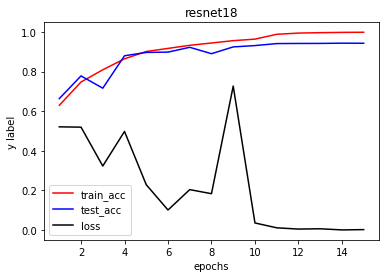

In [20]:
#绘图
import matplotlib.pyplot as plt
epochs=range(1,num_epochs+1)
# epochs=range(1,12)
# train_acc.pop()
# test_acc.pop()
# losses.pop()
print(f'train_acc{len(train_acc)},test_acc{(test_acc)},losses{len(losses)}')
plt.plot(epochs,train_acc,color='r',label='train_acc') # r表示红色
plt.plot(epochs,test_acc,color='b',label='test_acc') 
plt.plot(epochs,losses,color=(0,0,0),label='loss') #也可以用RGB值表示颜色
#####非必须内容#########
plt.xlabel('epochs') #x轴表示
plt.ylabel('y label') #y轴表示
plt.title("resnet18") #图标标题表示
plt.legend()  #每条折线的label显示
#######################
plt.savefig('./resnet18.jpg') #保存图片
plt.show()  #显示图片

In [ ]:
#保存权重跟模型
PATH='./model/final_change_resnet18_Cat_Dog_classification.pth'
torch.save(model, PATH)

In [21]:
#读取权重与模型并测试
new_model = models.resnet18()    
new_model = torch.load(PATH)
new_model.eval()
new_model.to(device)
logger.info('start testing!')
valid(new_model,device,valid_loader)  
logger.info('finish testing!')

[2022-05-16 11:53:46,299][1055870467.py][line:6][INFO] start testing!


本来类 ['猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫']
预测类 ['猫', '狗', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '狗', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '狗', '猫', '猫', '猫', '猫', '猫', '猫', '狗', '猫', '猫', '猫', '猫', '狗', '猫', '狗']
本来类 ['猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗']
预测类 ['猫', '猫', '猫', '猫', '猫', '狗', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '猫', '狗', '猫', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗']


[2022-05-16 11:53:49,639][2533203759.py][line:91][INFO] valid_acc=0.890
[2022-05-16 11:53:49,640][1055870467.py][line:8][INFO] finish testing!


本来类 ['狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗']
预测类 ['狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '猫', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '狗', '猫', '狗', '狗', '狗']
本来类 ['狗', '狗', '狗', '狗']
预测类 ['狗', '狗', '狗', '狗']
